## Сегментация опухолей мозга с помощью UNet

<img src="https://i.imgur.com/Q8oI4M6.png"
     align="right"
     width="300"
     style="padding: 20px;" />

Цель домашней работы - обучить [UNet](https://arxiv.org/abs/1505.04597) для сегментации опухолей головного мозга



### Загрузка данных
Данные представлены в виде питоновского словаря, где пары изображение-маска сохранены как .h5 файл, с ключами `image` и `mask`.

Датасет доступен по [ссылке](https://disk.yandex.ru/d/D_x_9woD55P8_g)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#dataset_directory = '/content/drive/MyDrive/dataset/archive/'

Mounted at /content/drive


In [2]:
# import zipfile

# # Путь к вашему zip-файлу
# zip_path = "/content/drive/MyDrive/dataset/archive(1).zip"
# # Папка, куда нужно извлечь файлы
# extract_to = "/content/drive/MyDrive/dataset/archive(2)"

# # С использованием контекстного менеджера 'with' можно открыть и извлечь содержимое файла.
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# print("Файлы успешно извлечены!")

In [3]:
dataset_directory = '/content/drive/MyDrive/dataset/archive(2)/'

In [5]:
import numpy as np
import os
import h5py

# Directory containing .h5 files
path_to_data = dataset_directory  # Change it accordingly
directory = f'{path_to_data}BraTS2020_training_data/content/data'

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
#    file_path = os.path.join(directory, h5_files[25070])3
    file_path = os.path.join(directory, h5_files[180]) #18000
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 18445 .h5 files:
Example file names:['volume_201_slice_36.h5', 'volume_201_slice_37.h5', 'volume_201_slice_38.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 5.160389307240086
Array min val: -0.6059851394208327

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0


## О данных
В нашема датасете снимки МРТ головного мозга вместе с маской, показывающий на абнормальные участки тканей головного мозга. У каждого изображения 4 канала

#### Каналы:
1) **T1-weighted (T1)**: Канал, хранящий в себе изображение структуры тканей головного мозга в высоком разрешении. Хорошо для визуализации структуры мозга, но не так чувствителен к тканям опухолей, как другие типы каналов.

2) **T1-weighted post contrast (T1c or T1Gd)**: После инъекции котрастного агента (обычно gadolinium), T1-weighted изображения берутся вновь. Контрастный агент улучшает видимость областей с высокой степенью васкуляторности (активности сосудов), что типично для тканей опухолей, таким образом является наиболее оптимальным для визуализации областей со злокачественными опухолями.

3) **T2-weighted (T2)**: T2 изображения обладают вылеколепной контрастностью жидкостных участков головного мозга и чувствительны к эдемам (отечностям), которые часто окружают опухоли (tumors). Помогает визуализировать как опухоли, так и ткани вокруг них.

4) **Fluid Attenuated Inversion Recovery (FLAIR)**: Эта маска подавляет жидкостный сигнал, упрощая доступность перитуморального отека для визуализации, а так же помогает лучше различать отек от спиномозговой жидкости.


В масках три канала:

#### Mask channels
1) **Necrotic and Non-Enhancing Tumour Core (NCR/NET)**: Маска для некротичных (мертвых) участков тканей опухоли, не подсвечивается контрастным агентом.

2) **Edema (ED)**: Эта маска подсвечивает эдему - припухлость тканей вокруг опухоли.

3) **Enhancing Tumour (ET)**: Показывает наиболее агрессивный регион опухоли.

### Viewing Sample Images
Воспользуемся матплотлибом для визуализации изобрадения и масок

Channel: T1-weighted (T1), Min: -0.6059851394208327, Max: 2.760551091439013
Channel: T1-weighted post contrast (T1c), Min: -0.603868099756642, Max: 2.517440184263926
Channel: T2-weighted (T2), Min: -0.5846853148772383, Max: 5.160389307240086
Channel: Fluid Attenuated Inversion Recovery (FLAIR), Min: -0.5919949508451517, Max: 4.6085685214070855


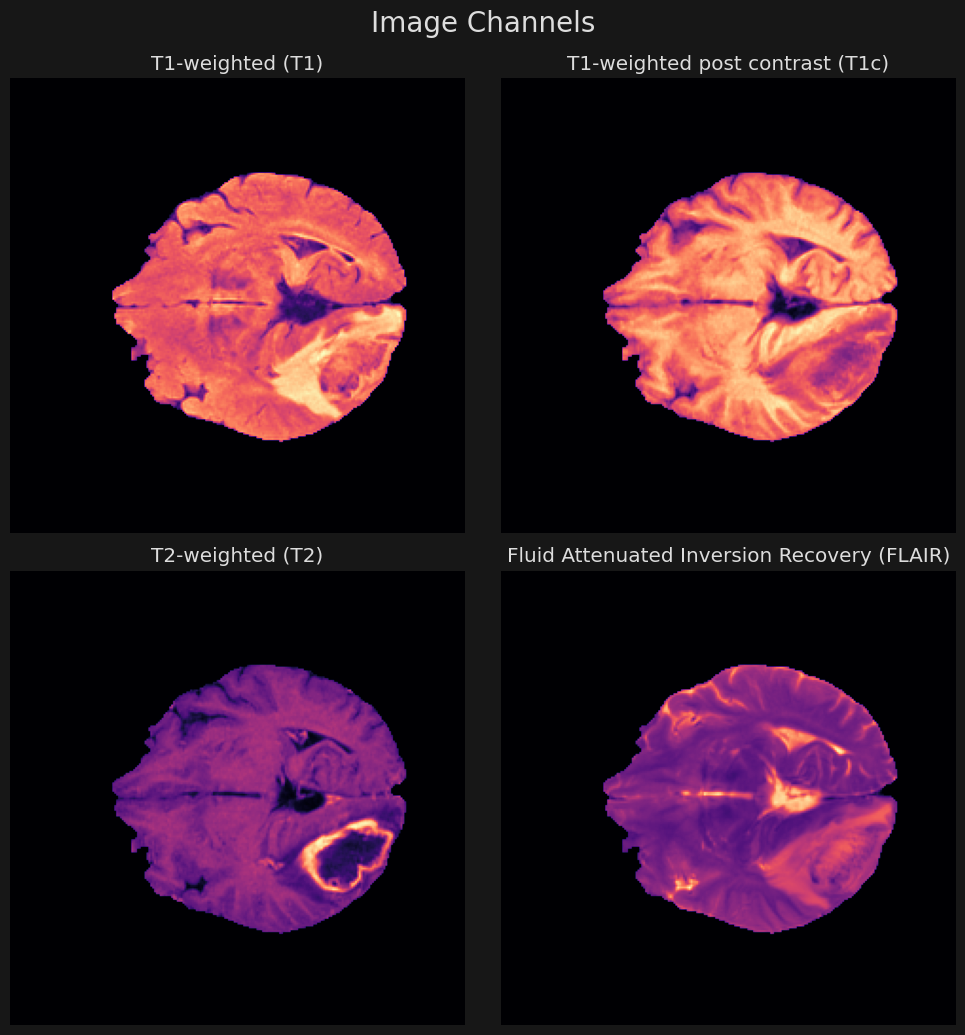

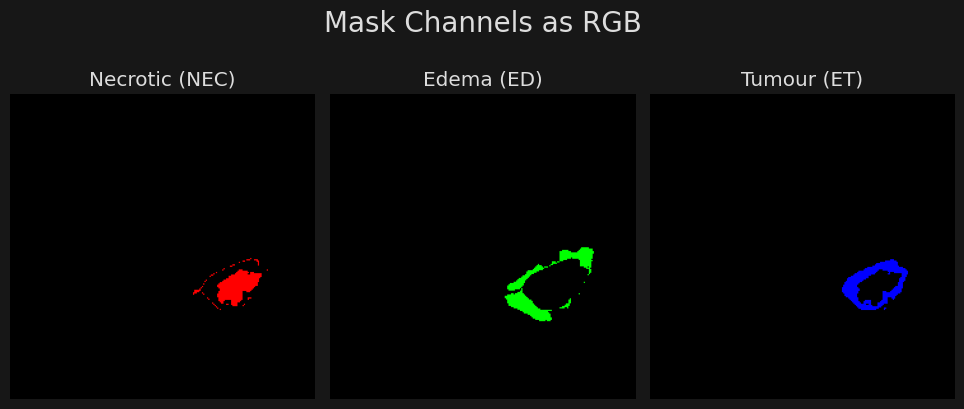

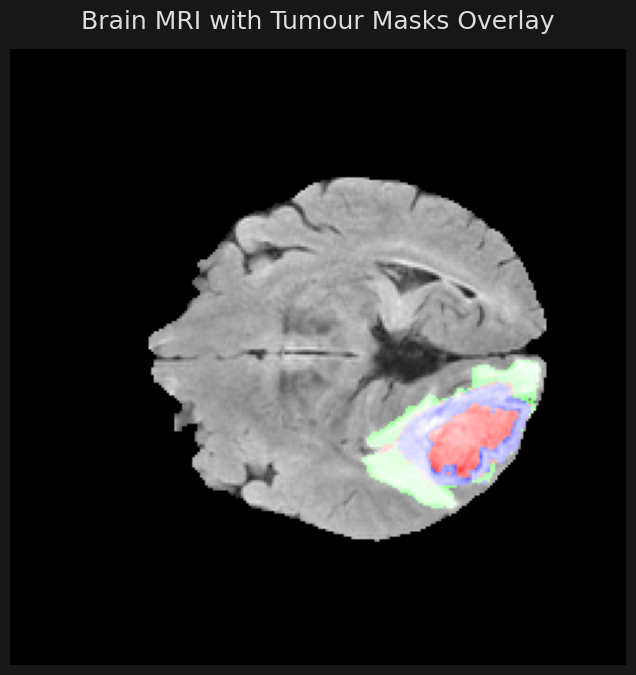

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    for i, channel_name in enumerate(channel_names):
      print(f"Channel: {channel_name}, Min: {image[i].min()}, Max: {image[i].max()}")

    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    epsilon = 1e-10  # epsilon
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min() + epsilon)

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()


# Sample image to view
sample_file_path = os.path.join(directory, h5_files[180]) #25070] #18000
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

Визуализация полезной маски и изображения:
Channel: T1-weighted (T1), Min: -0.6059851394208327, Max: 2.760551091439013
Channel: T1-weighted post contrast (T1c), Min: -0.603868099756642, Max: 2.517440184263926
Channel: T2-weighted (T2), Min: -0.5846853148772383, Max: 5.160389307240086
Channel: Fluid Attenuated Inversion Recovery (FLAIR), Min: -0.5919949508451517, Max: 4.6085685214070855


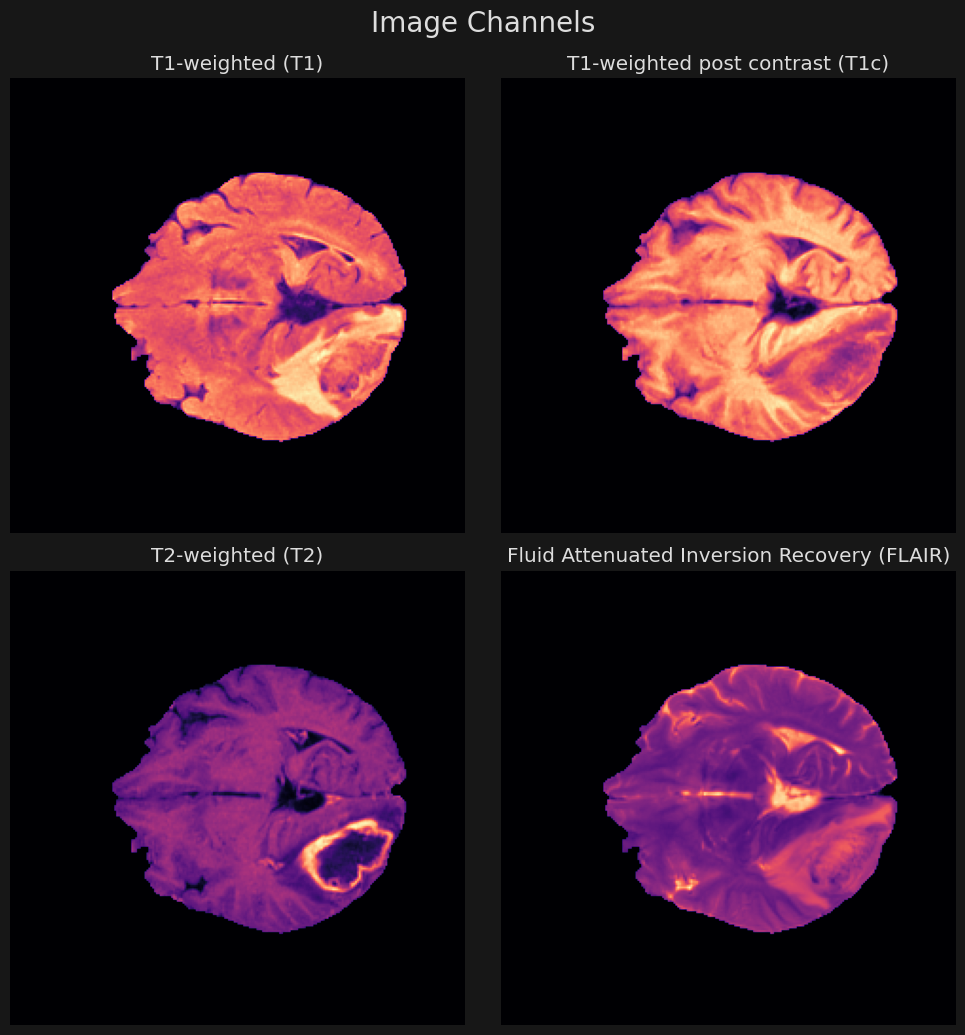

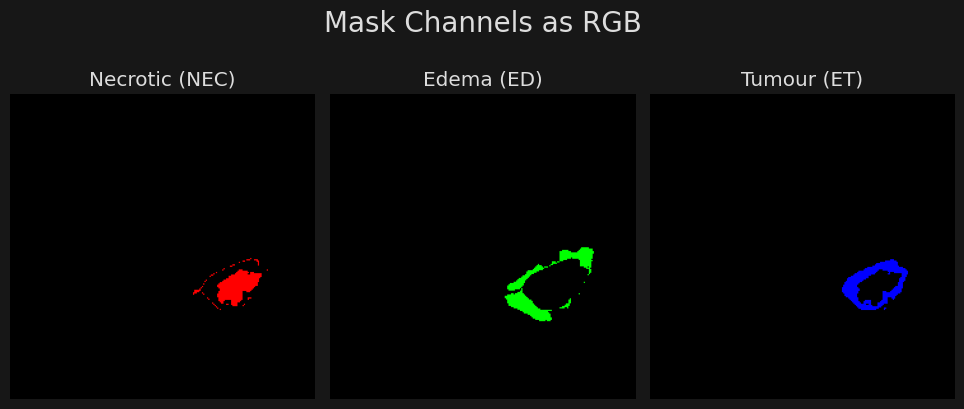

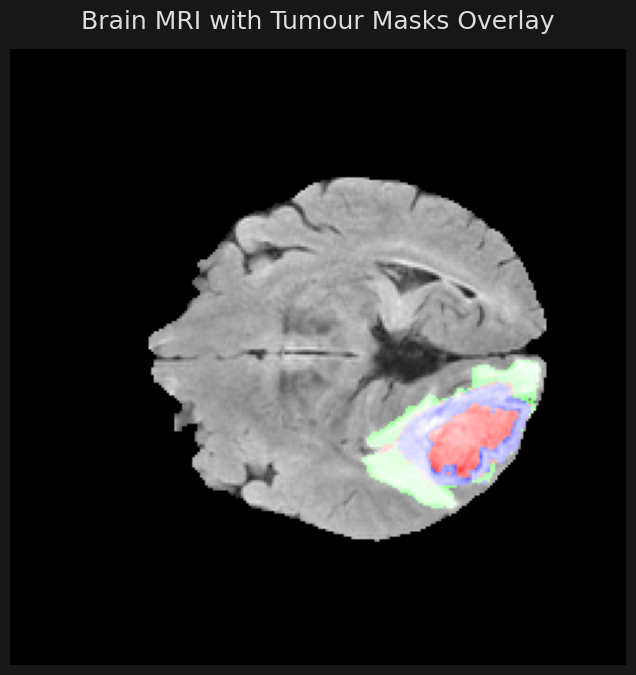

In [7]:
import os
import h5py
import numpy as np

# Sample image to view (assuming directory and h5_files are already defined)
if len(h5_files) > 180: #18000 # Ensure the index exists
    sample_file_path = os.path.join(directory, h5_files[180])#18000
    data = {}

    with h5py.File(sample_file_path, 'r') as file:
        for key in file.keys():
            data[key] = file[key][()]

    # Transpose the image and mask to have channels first
    image = data['image'].transpose(2, 0, 1)
    mask = data['mask'].transpose(2, 0, 1)

    # Check if any mask channel contains non-zero values (useful mask)
    if np.any(mask > 0):
        print("Визуализация полезной маски и изображения:")
        # View images using visualization functions
        display_image_channels(image)
        display_mask_channels_as_rgb(mask)
        overlay_masks_on_image(image, mask)
    else:
        print("Файл не содержит полезных масок, визуализация не произведена.")
else:
    print("Индекс файла вне диапазона доступных данных.")

Визуализация полезной маски и изображения из файла: volume_201_slice_46.h5
Channel: T1-weighted (T1), Min: -0.53697377850684, Max: 5.260107341471231
Channel: T1-weighted post contrast (T1c), Min: -0.5591993195042307, Max: 2.6656464718108746
Channel: T2-weighted (T2), Min: -0.5603896968839758, Max: 4.551545847329794
Channel: Fluid Attenuated Inversion Recovery (FLAIR), Min: -0.5477204319528413, Max: 4.267953177946942


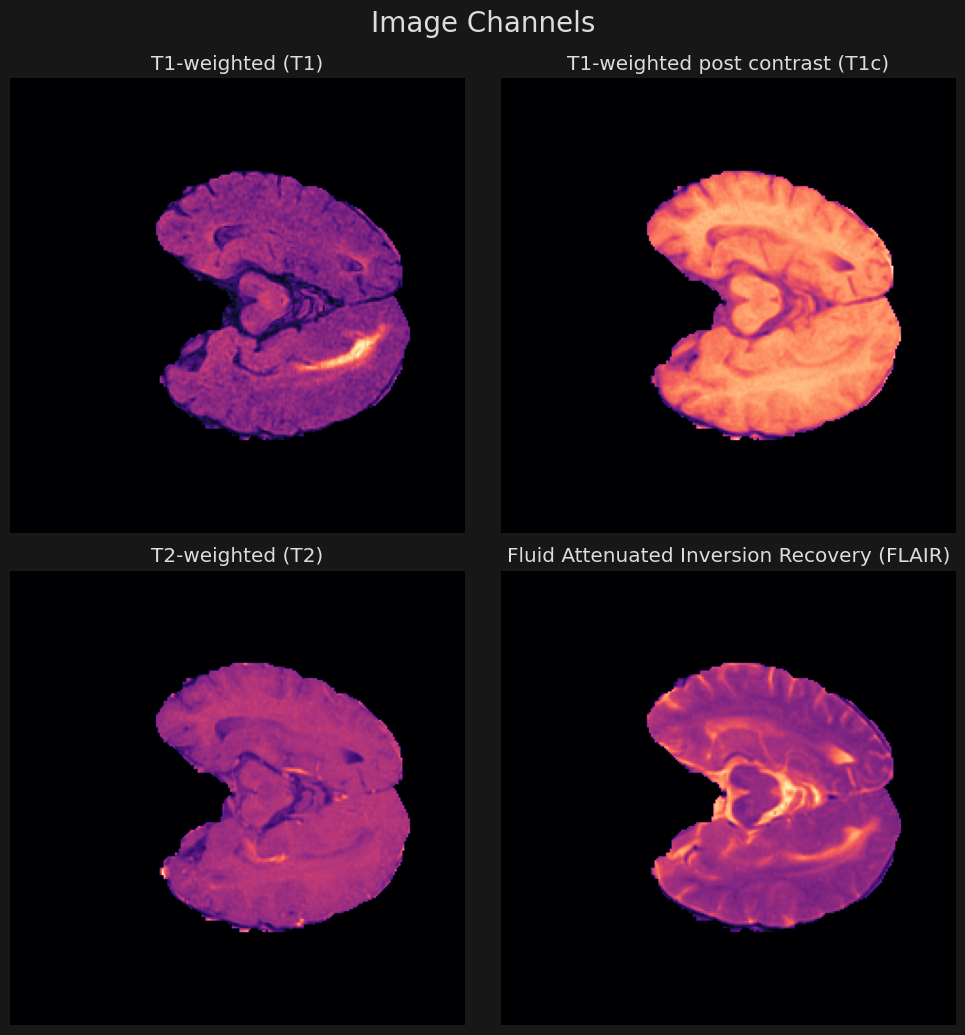

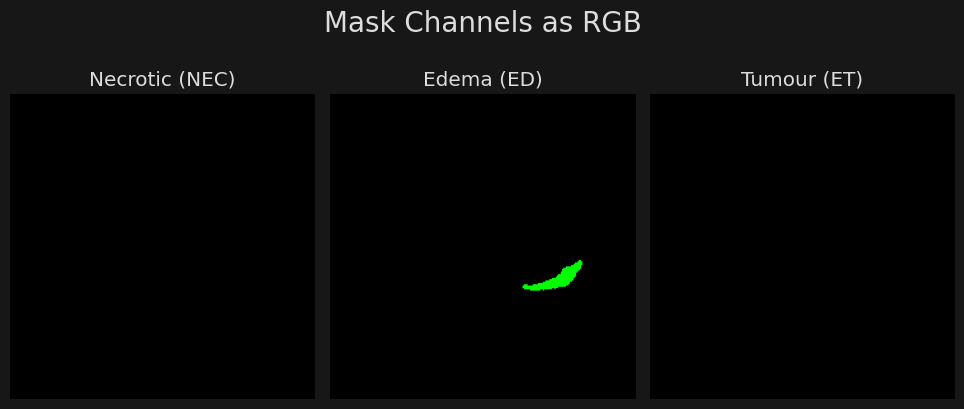

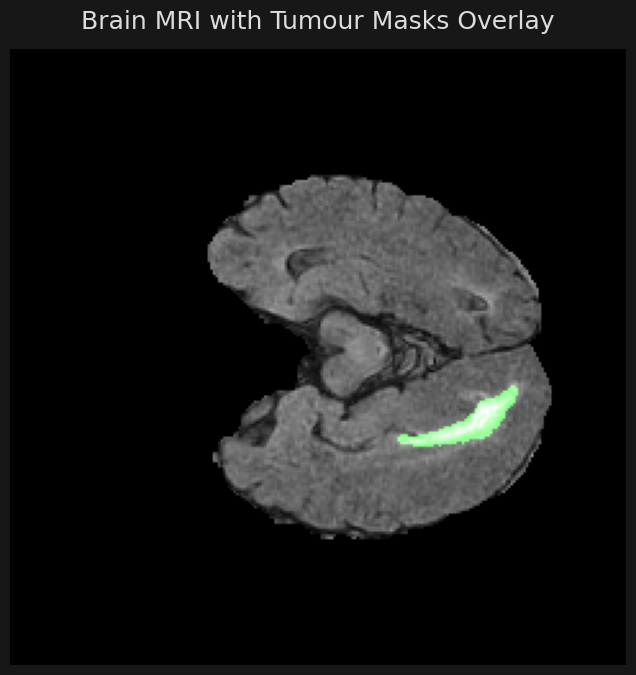

In [8]:
import os
import h5py
import numpy as np
import random

# Путь к директории с файлами .h5 (предполагаем, что directory уже определена)
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]

# Создаем список файлов с полезными масками
useful_files = []
for file_name in h5_files:
    if len(useful_files) >= 10:  # Проверяем, достаточно ли уже файлов в списке
      break
    file_path = os.path.join(directory, file_name)
    with h5py.File(file_path, 'r') as file:
        mask = file['mask'][()]
        if np.any(mask > 0):
            useful_files.append(file_name)

# Проверка, есть ли полезные файлы
if useful_files:
    # Выбираем случайный файл из списка полезных файлов
    random_file_name = random.choice(useful_files)
    sample_file_path = os.path.join(directory, random_file_name)
    data = {}

    with h5py.File(sample_file_path, 'r') as file:
        for key in file.keys():
            data[key] = file[key][()]

    # Транспонирование изображения и маски, чтобы каналы были первыми
    image = data['image'].transpose(2, 0, 1)
    mask = data['mask'].transpose(2, 0, 1)

    # Визуализация изображения и маски
    print(f"Визуализация полезной маски и изображения из файла: {random_file_name}")
    display_image_channels(image)
    display_mask_channels_as_rgb(mask)
    overlay_masks_on_image(image, mask)
else:
    print("Нет файлов с полезными масками для визуализации.")

### Создаем Dataset и DataLoader
Наш датасет относительно большой - ~8GB, поэтому возпользуемся dataloader для загрузки пар данных батчами. Посколько данные формат данных нестандартный, нам нужно написать свой собственный Dataset object и DataLoader.

Изображения сохранены в формате `float64` с интенсивностью пикселя от ~-0.5 до ~230 и `height`, `width`, `channels` последовательностью каналов. Маски сохраннены в `uint8` и пиксели там представлены 0 и 1.

Наш Dataset должен загрузить изображение, зарешейпить его в  `channels`, `height`, `width`, поправить значения пикселей чтобы минимум был в 0 на каждом изображении, затем каждый канал, чтобы максимум был 1, затем сконвертировать в  `torch.float32` tensor.

### 2 points

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader

class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]

            # Reshape: (H, W, C) -> (C, H, W)
            image = np.transpose(image, (2, 0, 1)) # YOUR CODE HERE #
            mask = np.transpose(mask, (2, 0, 1)) # YOUR CODE HERE #

            # Adjusting pixel values for each channel in the image so they are between 0 and 255
            for i in range(image.shape[0]):    # Iterate over channels
                 image[i] = (image[i] - np.min(image[i])) / (np.max(image[i]) - np.min(image[i]) + 1e-6) * 255 # YOUR CODE HERE #

            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    assert images.shape == torch.Size([5, 4, 240, 240])
    assert masks.shape == torch.Size([5, 3, 240, 240])
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


## Limited Loader for testing

In [32]:
# import torch
# from torch.utils.data import DataLoader

# def limited_loader(dataloader, limit):
#     """Generate a limited number of batches from a DataLoader."""
#     for i, data in enumerate(dataloader):
#         yield data
#         if i + 1 == limit:
#             break

# # Use the limited_loader to process just 10 batches
# limit_batches = 10

# train_limited_loader = limited_loader(train_dataloader, limit_batches)
# val_limited_loader = limited_loader(val_dataloader, limit_batches)

# # Example of using the limited loaders
# for i, (images, masks) in enumerate(train_limited_loader):
#     print(f"Batch {i+1} - Train - Images shape: {images.shape}, Masks shape: {masks.shape}")
#     # You can optionally insert break for ultra quick tests
#     # if i == 0:
#     #     break

# for i, (images, masks) in enumerate(val_limited_loader):
#     print(f"Batch {i+1} - Validation - Images shape: {images.shape}, Masks shape: {masks.shape}")



## The UNet Architecture

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"
     align="right"
     width="500"
     style="padding: 20px;" />
     
[UNet](https://arxiv.org/abs/1505.04597) is a deep learning neural network architecture originally designed for image segmentation tasks, but has since found use in GANs and latent diffusion models. Similar to autoencoders, the UNet structures include an encoder for compressing the input into a lower dimensional representation and a decoder for reconstructing the output from this compressed form. However, UNet distinguishes itself from autoencoders with several features:


Подсказка: skip_connection может быть реазлизована как с помощью torch.cat, так и torch.add

### 4 points

Мы с вами писали UNet на семинаре, здесь нужно сделать то же самое - можно как перенсти архитектуру оттуда, либо дополнить скелетный код, который дан ниже. Можно и полностью переписать весь код здесь, сохранив лишь его верхнеуровневую структуру - класс для энкодера и декодера блоков, класс для модели.

Глубину можно менять по своему вкусу, но рекомендую не менее 3х слоев в глубину.

In [34]:
# Function to count number of parameters in a model
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total Parameters: {total_params:,}\n')


In [35]:
import torch
from torch import nn

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.encoder_block(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            activation
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.decoder_block(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_block_1 = EncoderBlock(4, 32, nn.ReLU())
        self.enc_block_2 = EncoderBlock(32, 64, nn.ReLU())
        self.enc_block_3 = EncoderBlock(64, 128, nn.ReLU())
        self.enc_block_4 = EncoderBlock(128, 256, nn.ReLU())

        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.dec_block_4 = DecoderBlock(512, 128, nn.ReLU())
        self.dec_block_3 = DecoderBlock(256, 64, nn.ReLU())
        self.dec_block_2 = DecoderBlock(128, 32, nn.ReLU())
        self.dec_block_1 = DecoderBlock(64, 32, nn.ReLU())

        self.output = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        enc1, p1 = self.enc_block_1(x)
        enc2, p2 = self.enc_block_2(p1)
        enc3, p3 = self.enc_block_3(p2)
        enc4, p4 = self.enc_block_4(p3)

        b = self.bottleneck(p4)

        x = self.dec_block_4(b, enc4)
        x = self.dec_block_3(x, enc3)
        x = self.dec_block_2(x, enc2)
        x = self.dec_block_1(x, enc1)

        return self.output(x)

# Create an instance of the model and test it
model = UNet()
print(model)

# Check forward pass
input_tensor = torch.rand((1, 4, 256, 256))  # example input batch
output_tensor = model(input_tensor)
print(output_tensor.shape)

UNet(
  (enc_block_1): EncoderBlock(
    (encoder_block): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_block_2): EncoderBlock(
    (encoder_block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (pool): MaxPool2

### Training Loop


### 4 points

In [36]:
# YOU CAN REWRITE THIS ENTIRE BLOCK

def train_model(model, train_dataloader, val_dataloader, verbose=True):
    device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_epochs = 20 # YOUR CODE HERE #
    learning_rate = 0.001 # YOUR CODE HERE #
    batches_per_epoch =  min(100, len(train_dataloader)) # YOUR CODE HERE # You can reduce the amount of computing with that
    lr_decay_factor =  0.95 # YOUR CODE HERE #

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # YOUR CODE HERE #
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []

    print("Training...")
    for epoch in range(1, n_epochs + 1):\

        # Decay learning rate. Make it smaller with each epoch
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1)) # YOUR CODE HERE # Or you can leave it with learning_rate, thus disabling decaying

        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inputs = train_inputs.to(device) # YOUR CODE HERE #
            train_targets = train_targets.to(device) # YOUR CODE HERE #
            optimizer.zero_grad()
            train_preds = model(train_inputs) # YOUR CODE HERE #
            train_batch_loss = loss_fn(train_preds, train_targets) # YOUR CODE HERE #
            train_epoch_loss += train_batch_loss.item() # YOUR CODE HERE #

            train_batch_loss.backward()
            optimizer.step()

             # YOUR CODE HERE #
                ## something important here ##
             # YOUR CODE HERE #

            # FEEL FREE TO UNCOMMENT NEXT LINE TO REDUCE COMPUTATION.
        if train_batch_idx >= batches_per_epoch:   # if you want lesser batches amount per epoch
          if verbose: print()
          break
        #train_epoch_losses.append(train_epoch_loss)
        train_epoch_losses.append(train_epoch_loss / batches_per_epoch)

        # Val step
         # YOUR CODE HERE #
         # YOUR CODE HERE #
         # YOUR CODE HERE #
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for val_inputs, val_targets in val_dataloader:
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)
                val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()

        val_epoch_losses.append(val_epoch_loss / len(val_dataloader))

        if verbose: print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, lr {current_lr:.6f}\n")

    print("Training complete.")
    return train_epoch_losses, val_epoch_losses

In [37]:
# Fetch a single batch from the DataLoader
images, masks = next(iter(train_dataloader))

# Print the sizes
print(f"Size of images batch: {images.shape}")
print(f"Size of masks batch: {masks.shape}")

Size of images batch: torch.Size([5, 4, 240, 240])
Size of masks batch: torch.Size([5, 3, 240, 240])


In [38]:
print(f"Batch size: {train_dataloader.batch_size}")

Batch size: 5


In [39]:
total_batches = len(train_dataloader)
print(f"Total number of batches: {total_batches}")

Total number of batches: 3320


In [49]:
# YOU CAN HAVE A DICT WITH TRAING PARAMS AS EXPERIMENT CONFIG
import torch.optim as optim
from torch import nn
import torch

# Experiment configuration
# config = {
#     'epochs': 25,
#     'learning_rate': 1e-4,
#     'device': 'cuda' if torch.cuda.is_available() else 'cpu'
# }

# Experiment configuration
config = {
    'epochs': 5,
    'learning_rate': 1e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [ ]:
# Create UNet model and count params
model = UNet().to(config['device'])
count_parameters(model)   # I had 5,496,451 params

# Create optimizers
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.BCEWithLogitsLoss() # Binary cross entropy loss for multi-label classification

## Using whole dataset takes too long time, so I used batches limits to make learning process shorter.

In [51]:
def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, config):
    # Ensure model is on the correct device
    model = model.to(config['device'])

    train_losses = []
    val_losses = []

    # Set batch limits for debugging/testing
    train_batches_limit = config.get('train_batches_limit', None)
    val_batches_limit = config.get('val_batches_limit', None)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        train_count = 0

        for images, masks in train_loader:
            images = images.to(config['device'])
            masks = masks.to(config['device'])

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_count += 1
            if train_batches_limit and train_count >= train_batches_limit:
                break  # Stop training after reaching batch limit

        # Prevent division by zero
        if train_count > 0:
            train_losses.append(running_loss / train_count)
        else:
            train_losses.append(0.0)  # Append a zero loss if no batches were processed

        model.eval()
        running_val_loss = 0
        val_count = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(config['device'])
                masks = masks.to(config['device'])

                outputs = model(images)
                val_loss = criterion(outputs, masks)
                running_val_loss += val_loss.item()
                val_count += 1
                if val_batches_limit and val_count >= val_batches_limit:
                    break  # Stop validation after reaching batch limit

        # Prevent division by zero
        if val_count > 0:
            val_losses.append(running_val_loss / val_count)
        else:
            val_losses.append(0.0)  # Append a zero loss if no batches were processed

        if config.get('verbose', True):  # Enabled verbose by default for demonstration
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

In [55]:
# Configuring the limits
config.update({
    'train_batches_limit': 100,  # Only process 10 batches of training data
    'val_batches_limit': 50      # Only process 5 batches of validation data
})

# Now, call the train_model function with the updated configuration.
train_epoch_losses, val_epoch_losses = train_model(
    model, train_dataloader, val_dataloader, config['epochs'], optimizer, criterion, config
)

# Print out some of the results to check
print(f'First few training losses: {train_epoch_losses}')
print(f'First few validation losses: {val_epoch_losses}')

Epoch 1/5, Train Loss: 0.5160, Val Loss: 0.4951
Epoch 2/5, Train Loss: 0.4612, Val Loss: 0.4474
Epoch 3/5, Train Loss: 0.4135, Val Loss: 0.4207
Epoch 4/5, Train Loss: 0.3726, Val Loss: 0.3663
Epoch 5/5, Train Loss: 0.3343, Val Loss: 0.3172
First few training losses: [0.5159879049658775, 0.4612292408943176, 0.41351100623607634, 0.37260830581188203, 0.33427419304847716]
First few validation losses: [0.4951272523403168, 0.4474321097135544, 0.42066982567310335, 0.36633309483528137, 0.31724397420883177]


### Смотрим на результат
Здесь ничего менять не надо

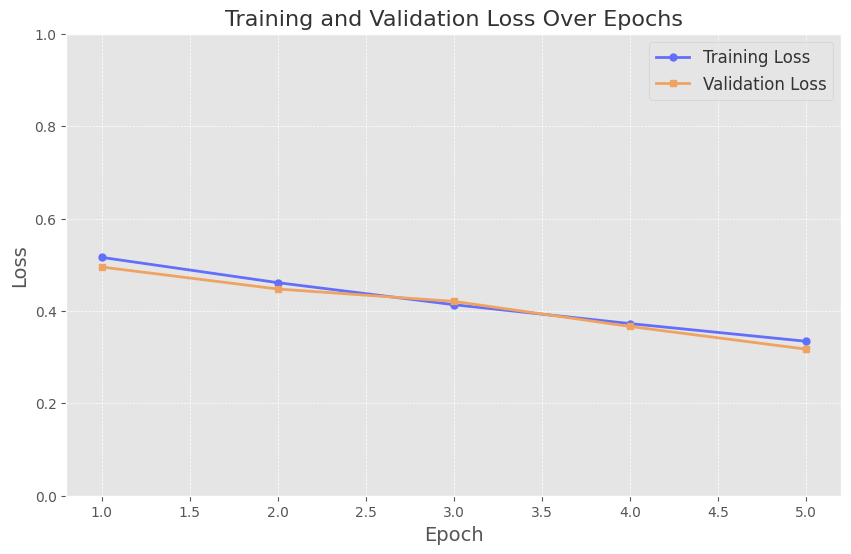

In [56]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 1)

    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

plot_learning_curves(train_epoch_losses, val_epoch_losses)

Channel: T1-weighted (T1), Min: 0.0, Max: 254.99993896484375
Channel: T1-weighted post contrast (T1c), Min: 0.0, Max: 254.9999237060547
Channel: T2-weighted (T2), Min: 0.0, Max: 254.9999542236328
Channel: Fluid Attenuated Inversion Recovery (FLAIR), Min: 0.0, Max: 254.99993896484375


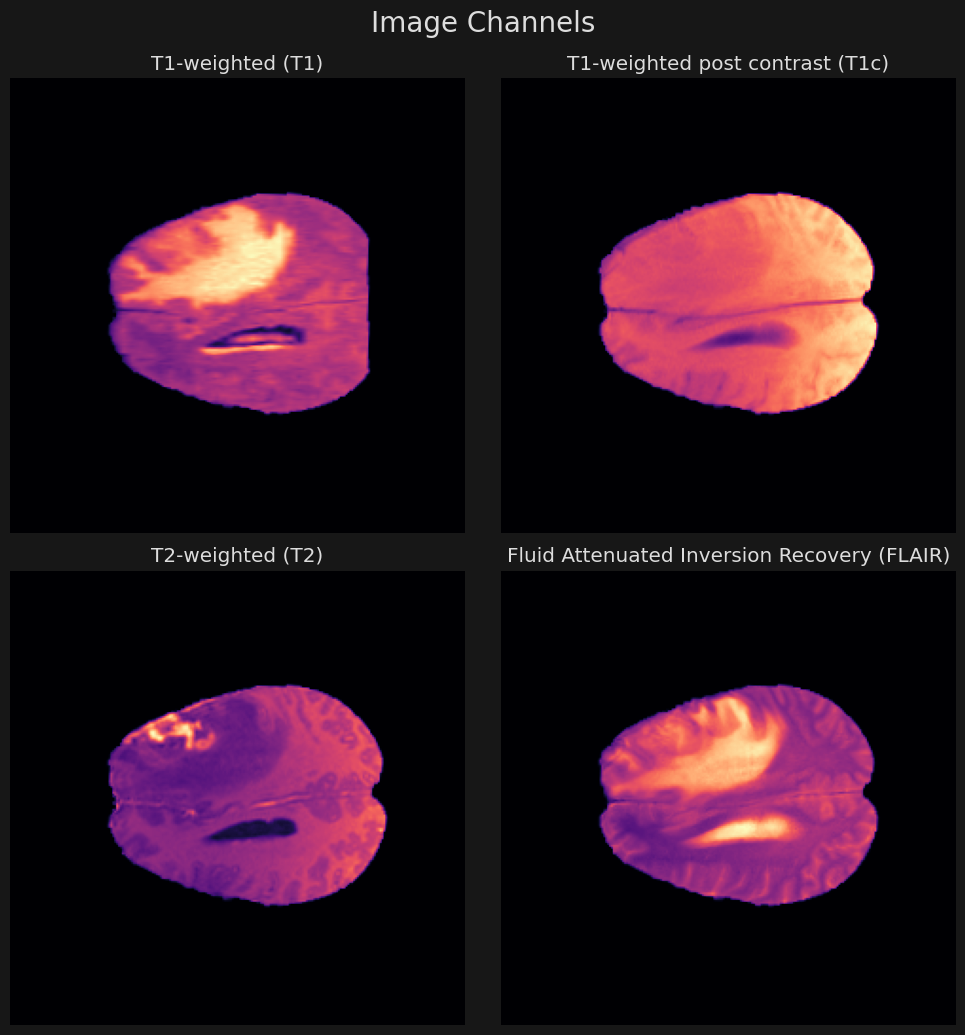

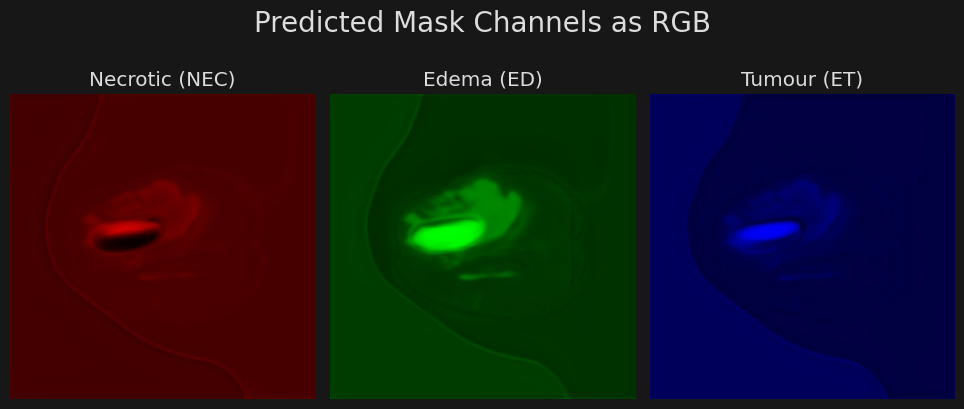

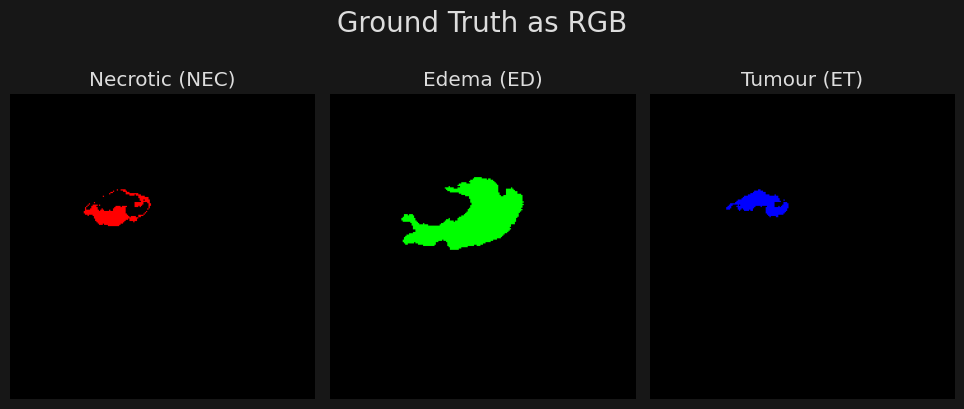

In [57]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')


# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)